# 1. Configuración

Este notebook replica el flujo del baseline de PANNs, pero insertando un bloque de **fine-tuning** más parecido al de MERT: además de una cabeza de proyección para embeddings, se permite **adaptación parcial del backbone** (últimos bloques convolucionales) para especializar el modelo al dominio EGFxSet.

Objetivos:

- Medir tiempo total de entrenamiento.
- Mantener protocolo de evaluación idéntico (Top‑1/Top‑5 por similitud coseno).
- Comparar con: (i) PANNs preentrenado, (ii) fine-tuning con cabeza congelando backbone, (iii) este experimento con backbone parcialmente entrenable.

## 1. Imports centralizados

Importa librerías base y define utilidades comunes.

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torchaudio
import soundfile as sf

import re

from tqdm import tqdm
import transformers
from transformers import AutoModel

/opt/anaconda3/envs/mert310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = Path("/Users/dtenreiro/Documents/TFM/EGFxSet")
OUT_DIR   = Path("./outputs_01_panns_base_egfxset")

OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists(), "->", DATA_ROOT)
print("OUT_DIR exists:", OUT_DIR.exists(), "->", OUT_DIR)

DATA_ROOT exists: True -> /Users/dtenreiro/Documents/TFM/EGFxSet
OUT_DIR exists: True -> outputs_01_panns_base_egfxset


## 2. Semilla y carpeta de salida

Fija semilla (reproducibilidad) y define el directorio de salida de este experimento (02).

In [3]:
import os, random
from pathlib import Path
import numpy as np
import torch

OUT_DIR_03 = Path("./outputs_03_panns_finetune_egfxset_unfreeze")
OUT_DIR_03.mkdir(parents=True, exist_ok=True)

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)
print("OUT_DIR_03:", OUT_DIR_03.resolve())


OUT_DIR_03: /Users/dtenreiro/Documents/TFM/panns_inference/outputs_03_panns_finetune_egfxset_unfreeze


## 3. Dispositivo

Selecciona `mps/cuda/cpu` igual que en el baseline.

In [4]:
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
device

if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))
elif device == "mps":
    print("Apple Silicon MPS enabled")
else:
    print("CPU only")

Apple Silicon MPS enabled


## 4. Sincronización para benchmarks

Define `_sync()` para que las medidas de tiempo sean correctas en GPU/MPS.

Para que el cronómetro mida de verdad en GPU/MPS


In [5]:
import time
import numpy as np
import torch

def _sync():
    if device == "cuda" and torch.cuda.is_available():
        torch.cuda.synchronize()
    elif device == "mps" and hasattr(torch, "mps"):
        try:
            torch.mps.synchronize()
        except Exception:
            pass

def _summ(times_s, label=""):
    times = np.array(times_s, dtype=np.float64)
    return {
        "label": label,
        "n": int(times.size),
        "mean_ms": float(times.mean() * 1000),
        "p50_ms": float(np.percentile(times, 50) * 1000),
        "p95_ms": float(np.percentile(times, 95) * 1000),
        "min_ms": float(times.min() * 1000),
        "max_ms": float(times.max() * 1000),
        "runs_per_s": float(1.0 / times.mean()),
    }

# 2. Carga del índice del dataset

Reutiliza el `egfxset_index.csv` generado por el baseline de PANNs para mantener el **mismo orden** y metadatos.

In [6]:
import pandas as pd
from pathlib import Path

INDEX_CSV_PATH = Path("./outputs_01_mert_base_egfxset/egfxset_index.csv")
assert INDEX_CSV_PATH.exists(), f"No encuentro {INDEX_CSV_PATH}. Ejecuta antes el notebook 01_PANNs_base_egfx."

df = pd.read_csv(INDEX_CSV_PATH)
print("Index:", df.shape)
df.head()


Index: (8947, 7)


,path,tone,pickup,tone_pickup,string,fret,midi_pitch
0,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,0,64
1,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,1,65
2,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,10,74
3,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,11,75
4,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,12,76


## 1. Configuración del objetivo de fine-tuning

La tarea de fine-tuning será **clasificar `tone_pickup`** (65 clases), como en el fine-tuning de MERT.

Guardamos el orden original (CRÍTICO: los embeddings se generan en el orden de `df`)
Split 80/20 estratificado por clase
Índices (filas) de df que pertenecen a train/val (para evaluar sobre validación sin recomputar embeddings)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

LABEL_COL = "tone_pickup"

df["row_id"] = np.arange(len(df), dtype=int)

le = LabelEncoder()
df["label_id"] = le.fit_transform(df[LABEL_COL].astype(str))
N_CLASSES = len(le.classes_)
print("N_CLASSES:", N_CLASSES)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df["label_id"]
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

train_idx = train_df["row_id"].to_numpy()
val_idx   = val_df["row_id"].to_numpy()

print("Train:", train_df.shape, "| Val:", val_df.shape)
print("train_idx:", train_idx.shape, "| val_idx:", val_idx.shape)

N_CLASSES: 65
Train: (7157, 9) | Val: (1790, 9)
train_idx: (7157,) | val_idx: (1790,)


# 3. PANNs: carga y fine-tuning

Cargamos PANNs CNN14 preentrenado (igual que en el baseline) y definimos una cabeza de clasificación para `tone_pickup`.

## 1. Parámetros de audio y utilidades de pooling

Se mantiene el mismo preprocesado (32 kHz, recorte/padding a 5 s).

Config audio para PANNs CNN14


In [8]:
MAX_SECONDS = 5.0
TARGET_SR = 32000  # <- PANNs CNN14 va a 32kHz

def load_audio_panns(path: str | Path):
    """Carga wav -> mono -> resample a 32kHz -> recorta a 5s"""
    wav, sr = sf.read(str(path))

    if wav.ndim == 2:
        wav = wav.mean(axis=1)

    wav = torch.from_numpy(wav).float()

    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        sr = TARGET_SR

    wav = wav[: int(sr * MAX_SECONDS)]
    return wav, sr

def temporal_pool(x: torch.Tensor, mode: str) -> torch.Tensor:
    """
    x: (T, D) ó (B, T, D). Devuelve (D) ó (B, D)
    """
    if x.dim() == 2:
        x0 = x
        if mode == "mean":
            return x0.mean(dim=0)
        elif mode == "max":
            return x0.max(dim=0).values
        elif mode == "stats":
            mu = x0.mean(dim=0)
            sd = x0.std(dim=0, unbiased=False)
            return torch.cat([mu, sd], dim=0)
        else:
            raise ValueError(f"Unknown mode: {mode}")

    if x.dim() == 3:
        if mode == "mean":
            return x.mean(dim=1)
        elif mode == "max":
            return x.max(dim=1).values
        elif mode == "stats":
            mu = x.mean(dim=1)
            sd = x.std(dim=1, unbiased=False)
            return torch.cat([mu, sd], dim=2)
        else:
            raise ValueError(f"Unknown mode: {mode}")

    raise ValueError(f"Unexpected tensor rank: {x.dim()}")

## 2. Dataset + DataLoaders

Construye un `Dataset` y un `collate_fn` que:
- Carga WAV
- Convierte a mono
- Re-muestrea a 32 kHz
- Recorta o **rellena con ceros** hasta 5 s

Esto permite hacer batches con tensores de longitud fija.

Padding a longitud fija (5s)


In [9]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

PATH_COL = "path"
LABEL_ID_COL = "label_id"

MAX_LEN = int(TARGET_SR * MAX_SECONDS)

def load_audio_fixed(path: str | Path):
    wav, sr = load_audio_panns(path)  # ya hace mono+resample+recorte
    if wav.numel() < MAX_LEN:
        pad = MAX_LEN - wav.numel()
        wav = torch.nn.functional.pad(wav, (0, pad))
    else:
        wav = wav[:MAX_LEN]
    return wav

class EGFxSetToneDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav = load_audio_fixed(row[PATH_COL])
        y = int(row[LABEL_ID_COL])
        return wav, y

def collate_fn(batch):
    wavs, ys = zip(*batch)
    x = torch.stack([w.float() for w in wavs], dim=0)  # (B, T)
    y = torch.tensor(ys, dtype=torch.long)
    return x, y

BATCH_SIZE = 16
train_loader = DataLoader(EGFxSetToneDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(EGFxSetToneDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

## 3. Cargar PANNs CNN14 + checkpoint

Reutiliza el mismo bloque del baseline para localizar y cargar el `.pth`.

In [10]:
from pathlib import Path
import urllib.request

OUT = Path("pretrained_models")
OUT.mkdir(parents=True, exist_ok=True)

url = "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1"
ckpt = OUT / "Cnn14_mAP=0.431.pth"

if not ckpt.exists():
    urllib.request.urlretrieve(url, ckpt)

PANNS_CNN14_CKPT = str(ckpt)
print("Checkpoint:", PANNS_CNN14_CKPT)

Checkpoint: pretrained_models/Cnn14_mAP=0.431.pth


1) Variable de entorno (si existe)
2) Buscar dentro del paquete instalado (rutas típicas)
3) Heurística: prioriza CNN14 si aparece en el nombre


In [11]:
from pathlib import Path
import os
import inspect
import torch
from panns_inference.models import Cnn14

def find_cnn14_ckpt() -> Path:
    env = os.environ.get("PANNS_CNN14_CKPT", "").strip()
    if env:
        p = Path(env).expanduser()
        if p.exists() and p.is_file():
            return p
        raise FileNotFoundError(f"PANNS_CNN14_CKPT apunta a algo que no es fichero: {p}")

    pkg_root = Path(inspect.getfile(Cnn14)).resolve().parent  # .../panns_inference/models
    candidates = []
    for rel in [
        "../pretrained_models",
        "../pretrained",
        "../data",
        "../../pretrained_models",
        "../../pretrained",
    ]:
        d = (pkg_root / rel).resolve()
        if d.exists() and d.is_dir():
            candidates += list(d.rglob("*.pth"))

    candidates = sorted(candidates, key=lambda p: (("cnn14" not in p.name.lower()), len(p.name)))
    if candidates:
        return candidates[0]

    raise FileNotFoundError(
        "No se ha encontrado ningún checkpoint .pth de PANNs CNN14.\n"
    )

CKPT = find_cnn14_ckpt()
print("Using checkpoint:", CKPT)

panns_model = Cnn14(
    sample_rate=TARGET_SR,
    window_size=1024,
    hop_size=320,
    mel_bins=64,
    fmin=50,
    fmax=14000,
    classes_num=527
)

ckpt = torch.load(CKPT, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
panns_model.load_state_dict(state, strict=True)

panns_model.to(device).eval()
print("Loaded PANNs:", panns_model.__class__.__name__, "on", device)

Using checkpoint: /Users/dtenreiro/Documents/TFM/panns_inference/pretrained_models/Cnn14_mAP=0.431.pth
Loaded PANNs: Cnn14 on mps


## 4. Modelo para fine-tuning

Crea un wrapper que:
- Obtiene el embedding global de PANNs (`out['embedding']`).
- Aplica una capa `Linear` para predecir `tone_pickup`.

Así podemos entrenar una cabeza ligera y, opcionalmente, descongelar una parte final del encoder.

## Fine-tuning con *projection head* + adaptación parcial del backbone

**Objetivo**: mejorar la calidad del espacio de embeddings para *retrieval* (Top‑1/Top‑5) manteniendo el pooling interno de PANNs, pero permitiendo una **adaptación controlada** de las **últimas capas** del encoder.

**Qué cambia respecto al notebook anterior**:
- Además de la proyección `2048 → 256`, se **descongelan** los últimos bloques convolucionales para que el modelo pueda especializarse al dominio EGFxSet (estrategia más cercana al fine‑tuning parcial aplicado en MERT).
- El resto del protocolo (split, ventanas, evaluación por similitud coseno) se mantiene idéntico para comparar de forma directa.


Inferimos emb_dim con un forward dummy (backbone en eval por seguridad)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PANNsForTonePickup(nn.Module):
    """Wrapper de fine-tuning para PANNs.

    - backbone: PANNs (CNN14) preentrenado
    - proj: proyección entrenable para compactar el embedding (mejor retrieval)
    - classifier: capa final de clasificación

    Nota: el pooling temporal interno de PANNs NO se modifica; aquí solo se adapta el embedding final.
    """
    def __init__(self, panns_backbone: nn.Module, emb_dim: int, proj_dim: int, n_classes: int):
        super().__init__()
        self.panns = panns_backbone
        self.proj = nn.Linear(emb_dim, proj_dim)
        self.classifier = nn.Linear(proj_dim, n_classes)

    def forward(self, x):
        out = self.panns(x, None)
        emb_raw = out["embedding"]               # (B, emb_dim) - embedding global de PANNs (pooling interno)
        emb = self.proj(emb_raw)                # (B, proj_dim) - embedding adaptado al dominio
        emb = F.normalize(emb, p=2, dim=-1)      # normalización L2 -> adecuado para similitud coseno
        logits = self.classifier(emb)
        return logits, emb, emb_raw

panns_model.eval()
with torch.no_grad():
    x0, _ = next(iter(train_loader))
    x0 = x0.to(device)
    out0 = panns_model(x0, None)
    emb_dim = int(out0["embedding"].shape[-1])

PROJ_DIM = 256
ft_model = PANNsForTonePickup(panns_model, emb_dim=emb_dim, proj_dim=PROJ_DIM, n_classes=N_CLASSES).to(device)
print("emb_dim:", emb_dim, "| proj_dim:", PROJ_DIM)


emb_dim: 2048 | proj_dim: 256


### 5. Fine-tuning parcial de PANNs (CNN14)

En este experimento se parte del modelo CNN14 preentrenado y se realiza un fine-tuning **parcial y controlado**, entrenando:
- La **cabeza de proyección** (2048→256) y la **capa de clasificación**.
- Un subconjunto reducido del encoder (los **últimos bloques convolucionales**), para adaptar las representaciones al dominio específico de guitarra eléctrica sin alterar por completo el conocimiento general aprendido en AudioSet.


## Política de congelación

Para maximizar la comparabilidad con el fine‑tuning de MERT y evitar inestabilidad:
- **Congelamos** la mayor parte del backbone PANNs.
- Entrenamos siempre:
  - `proj` (proyección 2048→256)
  - `classifier`
- Además, **descongelamos** únicamente los **últimos bloques** del encoder (por defecto `conv_block5` y `conv_block6`), manteniendo el resto fijo.

Esta estrategia busca un compromiso entre **adaptación al dominio** y **riesgo de sobreajuste**.


--- Freeze / Unfreeze policy (UNFREEZE BACKBONE + PROJECTION HEAD) ---
1) Congelar TODO el backbone
2) Proyección y clasificador entrenables
3) Unfreeze parcial del backbone (más parecido a MERT)
   - Activamos gradientes SOLO en los últimos bloques convolucionales.
Solo BatchNorm dentro del bloque
4) Nota: durante el loop de entrenamiento pondremos el backbone en eval()
   y solo estos bloques en train() para que BN/Dropout se comporten como queremos.


In [13]:
import torch.nn as nn

backbone = ft_model.panns  # referencia estable al backbone PANNs

for p in backbone.parameters():
    p.requires_grad = False

for p in ft_model.proj.parameters():
    p.requires_grad = True
for p in ft_model.classifier.parameters():
    p.requires_grad = True

UNFREEZE_BLOCKS = ["conv_block5", "conv_block6"]  # ajustable
UNFREEZE_BN_ONLY = False  # si True, solo BN de esos bloques

def _set_trainable(module: nn.Module, trainable: bool):
    for p in module.parameters():
        p.requires_grad = trainable

for name in UNFREEZE_BLOCKS:
    if not hasattr(backbone, name):
        raise AttributeError(f"Backbone no tiene atributo '{name}'. Revisa nombres disponibles en backbone.")
    block = getattr(backbone, name)
    if UNFREEZE_BN_ONLY:
        for m in block.modules():
            if isinstance(m, nn.BatchNorm2d):
                for p in m.parameters():
                    p.requires_grad = True
    else:
        _set_trainable(block, True)

print("UNFREEZE_BLOCKS:", UNFREEZE_BLOCKS, "| UNFREEZE_BN_ONLY:", UNFREEZE_BN_ONLY)


UNFREEZE_BLOCKS: ['conv_block5', 'conv_block6'] | UNFREEZE_BN_ONLY: False


--- Verificación exacta: cuántos parámetros entrenables por módulo ---
Asegura que NO hay nada entrenable fuera de esos dos


In [14]:
def count_params(module):
    return sum(p.numel() for p in module.parameters())

def count_trainable_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

print("Trainable total:", sum(p.numel() for p in ft_model.parameters() if p.requires_grad))

print("Trainable classifier:", count_trainable_params(ft_model.classifier), "/", count_params(ft_model.classifier))

print("Trainable conv_block6:", count_trainable_params(ft_model.panns.conv_block6), "/", count_params(ft_model.panns.conv_block6))

others = []
for name, p in ft_model.named_parameters():
    if p.requires_grad and not (name.startswith("panns.conv_block6.") or name.startswith("classifier.")):
        others.append(name)
print("Otros entrenables fuera de conv_block6+classifier:", others[:20], " (n=", len(others), ")")

Trainable total: 71332417
Trainable classifier: 16705 / 16705
Trainable conv_block6: 56631296 / 56631296
Otros entrenables fuera de conv_block6+classifier: ['panns.conv_block5.conv1.weight', 'panns.conv_block5.conv2.weight', 'panns.conv_block5.bn1.weight', 'panns.conv_block5.bn1.bias', 'panns.conv_block5.bn2.weight', 'panns.conv_block5.bn2.bias', 'proj.weight', 'proj.bias']  (n= 8 )


## 6. Loop de entrenamiento

Entrena con `CrossEntropyLoss`, early stopping por `val_loss` y guarda el mejor estado.

También mide el **tiempo total de entrenamiento** (wall-clock).

## Control explícito de `train()` / `eval()`

Aunque el backbone esté congelado (sin gradiente), **BatchNorm/Dropout** pueden comportarse distinto según `train()`/`eval()`.
Aquí dejamos el backbone global en `eval()` para evitar deriva de estadísticos, y si `UNFREEZE_BN_BLOCK6=True` activamos solo `conv_block6` en `train()` para permitir adaptación de BN en ese bloque.


--- IMPORTANT: control train/eval modes (PROJECTION HEAD) ---


In [15]:
backbone = ft_model.panns

backbone.eval()                 # congela Dropout/BN del backbone
ft_model.proj.train()           # entrena proyección
ft_model.classifier.train()     # entrena clasificador

if 'UNFREEZE_BN_BLOCK6' in globals() and UNFREEZE_BN_BLOCK6:
    backbone.conv_block6.train()  # solo BN de conv_block6 puede adaptarse


## Entrenamiento

Entrenamos únicamente los parámetros marcados como entrenables (proyección + classifier + BN opcional).
En cada época fijamos el modo de trabajo:
- backbone en `eval()`
- `proj` y `classifier` en `train()`
- (opcional) `conv_block6` en `train()` si queremos adaptar BN.

Además, como el `forward` ahora devuelve `(logits, emb_proj, emb_raw)`, usamos `logits` para la pérdida y mantenemos `emb_proj` para extracción posterior.


LRs separados: cabeza más rápida, backbone más lenta (estilo fine-tuning parcial)
--- Param groups ---
Por defecto mantenemos el backbone en eval() (estable) y activamos train() solo en los bloques descongelados.
--- Train ---
--- Val ---
Early stopping


In [16]:
from tqdm import tqdm
import time
import copy

criterion = nn.CrossEntropyLoss()

LR_HEAD = 1e-4
LR_BACKBONE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS_MAX = 30
PATIENCE = 6
GRAD_CLIP = 1.0
MIN_DELTA = 1e-3

best_val = float("inf")
best_state = None
best_epoch = -1
no_improve = 0

head_params = [p for p in list(ft_model.proj.parameters()) + list(ft_model.classifier.parameters()) if p.requires_grad]
backbone_params = [p for p in ft_model.panns.parameters() if p.requires_grad]

print(f"Parámetros entrenables (head): {sum(p.numel() for p in head_params):,}")
print(f"Parámetros entrenables (backbone): {sum(p.numel() for p in backbone_params):,}")
print(f"Parámetros entrenables (total): {sum(p.numel() for p in ft_model.parameters() if p.requires_grad):,} / {sum(p.numel() for p in ft_model.parameters()):,}")

param_groups = [
    {"params": head_params, "lr": LR_HEAD, "weight_decay": WEIGHT_DECAY},
]
if len(backbone_params) > 0:
    param_groups.append({"params": backbone_params, "lr": LR_BACKBONE, "weight_decay": WEIGHT_DECAY})

optimizer = torch.optim.AdamW(param_groups)

history = []
t0 = time.time()

def _set_backbone_train_mode():
    ft_model.panns.eval()
    for name in UNFREEZE_BLOCKS:
        block = getattr(ft_model.panns, name)
        block.train()

for epoch in range(1, EPOCHS_MAX + 1):
    ft_model.train()
    _set_backbone_train_mode()
    ft_model.proj.train()
    ft_model.classifier.train()

    tr_loss = 0.0
    tr_correct = 0
    tr_n = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS_MAX} [train]"):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits, emb, emb_raw = ft_model(x)
        loss = criterion(logits, y)
        loss.backward()

        if GRAD_CLIP is not None:
            torch.nn.utils.clip_grad_norm_(ft_model.parameters(), GRAD_CLIP)

        optimizer.step()

        tr_loss += float(loss.item()) * x.size(0)
        tr_correct += int((logits.argmax(dim=1) == y).sum().item())
        tr_n += x.size(0)

    tr_loss /= max(1, tr_n)
    tr_acc = tr_correct / max(1, tr_n)

    ft_model.eval()
    va_loss = 0.0
    va_correct = 0
    va_n = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS_MAX} [val]"):
            x = x.to(device)
            y = y.to(device)
            logits, emb, emb_raw = ft_model(x)
            loss = criterion(logits, y)

            va_loss += float(loss.item()) * x.size(0)
            va_correct += int((logits.argmax(dim=1) == y).sum().item())
            va_n += x.size(0)

    va_loss /= max(1, va_n)
    va_acc = va_correct / max(1, va_n)

    history.append({"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc, "val_loss": va_loss, "val_acc": va_acc})
    print(f"Epoch {epoch}: train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

    if va_loss < best_val - MIN_DELTA:
        best_val = va_loss
        best_epoch = epoch
        best_state = copy.deepcopy(ft_model.state_dict())
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (best epoch={best_epoch}, best val_loss={best_val:.4f})")
            break

train_time_s = time.time() - t0
print(f"Training time: {train_time_s/60:.2f} min ({train_time_s:.1f} s)")


Parámetros entrenables (head): 541,249
Parámetros entrenables (backbone): 70,791,168
Parámetros entrenables (total): 71,332,417 / 82,378,320


Epoch 1/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:10<00:00, 10.22it/s]


Epoch 1: train_loss=4.0166 train_acc=0.2138 | val_loss=3.8376 val_acc=0.4196


Epoch 2/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.68it/s]


Epoch 2: train_loss=3.7157 train_acc=0.4802 | val_loss=3.5703 val_acc=0.5514


Epoch 3/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.67it/s]


Epoch 3: train_loss=3.4653 train_acc=0.5894 | val_loss=3.3278 val_acc=0.6240


Epoch 4/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.64it/s]


Epoch 4: train_loss=3.2302 train_acc=0.6490 | val_loss=3.0999 val_acc=0.6754


Epoch 5/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.92it/s]


Epoch 5: train_loss=3.0070 train_acc=0.6946 | val_loss=2.8823 val_acc=0.7140


Epoch 6/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.40it/s]


Epoch 6: train_loss=2.7946 train_acc=0.7387 | val_loss=2.6776 val_acc=0.7419


Epoch 7/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.86it/s]


Epoch 7: train_loss=2.5911 train_acc=0.7714 | val_loss=2.4836 val_acc=0.7709


Epoch 8/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.97it/s]


Epoch 8: train_loss=2.4006 train_acc=0.7878 | val_loss=2.2952 val_acc=0.8134


Epoch 9/30 [val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.54it/s]


Epoch 9: train_loss=2.2152 train_acc=0.8151 | val_loss=2.1187 val_acc=0.8251


Epoch 10/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.84it/s]


Epoch 10: train_loss=2.0436 train_acc=0.8393 | val_loss=1.9526 val_acc=0.8363


Epoch 11/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.13it/s]


Epoch 11: train_loss=1.8837 train_acc=0.8561 | val_loss=1.7991 val_acc=0.8559


Epoch 12/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.60it/s]


Epoch 12: train_loss=1.7348 train_acc=0.8671 | val_loss=1.6551 val_acc=0.8687


Epoch 13/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 13.01it/s]


Epoch 13: train_loss=1.5921 train_acc=0.8825 | val_loss=1.5192 val_acc=0.8821


Epoch 14/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.80it/s]


Epoch 14: train_loss=1.4577 train_acc=0.9015 | val_loss=1.3927 val_acc=0.8927


Epoch 15/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.79it/s]


Epoch 15: train_loss=1.3329 train_acc=0.9032 | val_loss=1.2763 val_acc=0.9000


Epoch 16/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:10<00:00, 10.84it/s]


Epoch 16: train_loss=1.2185 train_acc=0.9201 | val_loss=1.1695 val_acc=0.8966


Epoch 17/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.90it/s]


Epoch 17: train_loss=1.1090 train_acc=0.9241 | val_loss=1.0678 val_acc=0.9106


Epoch 18/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.14it/s]


Epoch 18: train_loss=1.0110 train_acc=0.9328 | val_loss=0.9766 val_acc=0.9179


Epoch 19/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.96it/s]


Epoch 19: train_loss=0.9218 train_acc=0.9381 | val_loss=0.8898 val_acc=0.9240


Epoch 20/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.96it/s]


Epoch 20: train_loss=0.8360 train_acc=0.9497 | val_loss=0.8102 val_acc=0.9257


Epoch 21/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:08<00:00, 12.74it/s]


Epoch 21: train_loss=0.7572 train_acc=0.9497 | val_loss=0.7421 val_acc=0.9291


Epoch 22/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.29it/s]


Epoch 22: train_loss=0.6830 train_acc=0.9553 | val_loss=0.6736 val_acc=0.9330


Epoch 23/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.35it/s]


Epoch 23: train_loss=0.6155 train_acc=0.9591 | val_loss=0.6100 val_acc=0.9330


Epoch 24/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.36it/s]


Epoch 24: train_loss=0.5539 train_acc=0.9638 | val_loss=0.5551 val_acc=0.9419


Epoch 25/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.18it/s]


Epoch 25: train_loss=0.4969 train_acc=0.9704 | val_loss=0.5060 val_acc=0.9397


Epoch 26/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.06it/s]


Epoch 26: train_loss=0.4437 train_acc=0.9736 | val_loss=0.4577 val_acc=0.9419


Epoch 27/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 12.02it/s]


Epoch 27: train_loss=0.3926 train_acc=0.9778 | val_loss=0.4184 val_acc=0.9413


Epoch 28/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.89it/s]


Epoch 28: train_loss=0.3496 train_acc=0.9803 | val_loss=0.3815 val_acc=0.9458


Epoch 29/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.68it/s]


Epoch 29: train_loss=0.3083 train_acc=0.9849 | val_loss=0.3509 val_acc=0.9464


Epoch 30/30 [val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:09<00:00, 11.30it/s]

Epoch 30: train_loss=0.2730 train_acc=0.9866 | val_loss=0.3140 val_acc=0.9531
Training time: 35.30 min (2118.2 s)


--- Guardar mejor modelo y métricas de entrenamiento ---
Carga el mejor estado en el modelo para el resto del notebook
Guardar el último estado por si acaso


In [17]:
import pandas as pd
import torch

HIST_CSV = OUT_DIR_03 / "train_history.csv"
pd.DataFrame(history).to_csv(HIST_CSV, index=False)
print("Saved:", HIST_CSV.resolve())

BEST_PT = OUT_DIR_03 / "best.pt"
LAST_PT = OUT_DIR_03 / "last.pt"

if best_state is not None:
    ft_model.load_state_dict(best_state)
    torch.save({
        "state_dict": best_state,
        "best_epoch": best_epoch,
        "best_val_loss": best_val,
        "unfreeze_blocks": UNFREEZE_BLOCKS,
        "unfreeze_bn_only": UNFREEZE_BN_ONLY,
        "lr_head": LR_HEAD,
        "lr_backbone": LR_BACKBONE,
    }, BEST_PT)
    print("Saved best:", BEST_PT.resolve())
else:
    print("WARNING: best_state es None (no se guardó best.pt)")

torch.save({
    "state_dict": ft_model.state_dict(),
    "epoch_end": history[-1]["epoch"] if len(history) else None,
    "unfreeze_blocks": UNFREEZE_BLOCKS,
    "unfreeze_bn_only": UNFREEZE_BN_ONLY,
}, LAST_PT)
print("Saved last:", LAST_PT.resolve())


Saved: /Users/dtenreiro/Documents/TFM/panns_inference/outputs_03_panns_finetune_egfxset_unfreeze/train_history.csv
Saved best: /Users/dtenreiro/Documents/TFM/panns_inference/outputs_03_panns_finetune_egfxset_unfreeze/best.pt
Saved last: /Users/dtenreiro/Documents/TFM/panns_inference/outputs_03_panns_finetune_egfxset_unfreeze/last.pt


# 4. Benchmarks de inferencia (modelo fine-tuned)

Repite las mismas medidas que en el baseline:
- **End-to-end**: carga + resample + forward + CPU/pooling
- **Forward puro**: waveform ya preparado y solo forward

## 1. Utilidad `savefig`

Guarda figuras en `outputs_03_panns_finetune_egfxset_unfreeze/figures_panns_ft`.

Carpeta donde guardar figuras


In [18]:
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = OUT_DIR_03 / "figures_panns_ft"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=300):
    out = FIG_DIR / f"{name}.png"
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)


## 2. Función de extracción de embeddings (fine-tuned)

Mismo formato que el baseline, pero usando el backbone fine-tuned.

## Extracción de embeddings (para evaluación Top‑1/Top‑5)

Guardamos dos variantes:
- `global_raw`: embedding global original de PANNs (2048)
- `global_proj`: embedding proyectado y normalizado (256) -> **el candidato principal** para retrieval

Opcionalmente mantenemos las variantes framewise (si existen) usando el framewise output del backbone.


Embedding proyectado (normalizado) desde el wrapper FT
También obtenemos salidas del backbone para framewise (si quieres comparar pooling temporal)
Global raw (2048) y global projected (256, L2)
Framewise (si existe) -> pooling temporal clásico sobre framewise output


In [19]:
def extract_panns_variants_ft(path):
    """Devuelve dict {variant: embedding_1D_cpu}."""
    x, sr = load_audio_panns(path)
    x = x.to(device).unsqueeze(0)  # (1, n)

    variants = {}

    with torch.no_grad():
        _, emb_proj, emb_raw = ft_model(x)

        out_backbone = ft_model.panns(x, None)

    variants["global_raw"]  = emb_raw.squeeze(0).float().cpu()
    variants["global_proj"] = emb_proj.squeeze(0).float().cpu()

    frame = None
    if "framewise_embedding" in out_backbone:
        frame = out_backbone["framewise_embedding"]  # (B, T, D)
    elif "framewise_output" in out_backbone:
        frame = out_backbone["framewise_output"]     # (B, T, D) o (B, T, C)

    if frame is not None:
        frame = frame.squeeze(0).float().cpu()  # (T, D)
        variants["frame_mean"]  = temporal_pool(frame, "mean")
        variants["frame_max"]   = temporal_pool(frame, "max")
        variants["frame_stats"] = temporal_pool(frame, "stats")

    return variants


## 3. Benchmark end-to-end (fine-tuned)

Mide latencia por muestra incluyendo I/O y preprocesado.

--- Benchmark end-to-end: load + resample + forward + cpu + pooling ---
warmup (sin medir)


In [20]:
paths_bench = df["path"].tolist()

n_warmup = 10
n_runs = 50  # sube si quieres más estabilidad

for p in paths_bench[:n_warmup]:
    _ = extract_panns_variants_ft(p)

times = []
for p in paths_bench[:n_runs]:
    _sync()
    t0 = time.perf_counter()
    _ = extract_panns_variants_ft(p)
    _sync()
    t1 = time.perf_counter()
    times.append(t1 - t0)

stats_e2e = _summ(times, label="E2E extract_panns_variants_ft (I/O+resample+forward+pool)")
stats_e2e

{'label': 'E2E extract_panns_variants_ft (I/O+resample+forward+pool)',
 'n': 50,
 'mean_ms': 13.332362540022586,
 'p50_ms': 13.10689550018651,
 'p95_ms': 15.4696640997372,
 'min_ms': 11.250834000748,
 'max_ms': 16.559084000618896,
 'runs_per_s': 75.00546110999363}

## 4. Benchmark forward puro (fine-tuned)

Mide exclusivamente el forward del modelo sobre un waveform ya preparado.

Prepara 1 waveform ya en device, evitando sf.read + resample cada vez
warmup


In [21]:
p0 = df["path"].iloc[0]
wav, sr = load_audio_panns(p0)        # incluye resample una vez
x = wav.to(device).unsqueeze(0)       # (1, n)

ft_model.panns.eval()

n_warmup = 30
n_runs = 200

with torch.inference_mode():
    for _ in range(n_warmup):
        _ = ft_model.panns(x, None)
    _sync()

    times = []
    for _ in range(n_runs):
        _sync()
        t0 = time.perf_counter()
        _ = ft_model.panns(x, None)
        _sync()
        t1 = time.perf_counter()
        times.append(t1 - t0)

stats_forward = _summ(times, label="FORWARD ONLY ft_model.panns(x)")
stats_forward

{'label': 'FORWARD ONLY ft_model.panns(x)',
 'n': 200,
 'mean_ms': 5.919684980040074,
 'p50_ms': 5.718041500131221,
 'p95_ms': 7.288552399722902,
 'min_ms': 5.114417000186222,
 'max_ms': 8.33320800029469,
 'runs_per_s': 168.92790805115283}

# 5. Embeddings tras fine-tuning

Extrae embeddings para **todo** el dataset, guardándolos en memmaps dentro de `outputs_02_...`.

## Generación masiva de embeddings en disco

Se generan ficheros `.npy` para todas las variantes retornadas por `extract_panns_variants_ft`.
En este experimento, la variante clave es `global_proj` (256), ya normalizada L2 en el `forward`.
Aun así, en la evaluación aplicamos una normalización L2 adicional por seguridad (no hace daño).


--- Pre-alloc y extracción masiva de embeddings PANNs (fine-tuned) ---
Sondeo de variantes y dimensiones (una muestra)
Crear memmaps en disco (uno por variante)
Guardar primer embedding (ya calculado)
Loop principal
Fallback seguro: si falta una variante, usa global_proj y si no, global_raw
Flush explícito a disco


In [22]:
from tqdm import tqdm
import numpy as np

paths = df["path"].tolist()
N = len(paths)

test_vars = extract_panns_variants_ft(paths[0])
dims = {k: v.numel() for k, v in test_vars.items()}
print("Variants/dims:", dims)

out_memmaps = {}
for variant, dim in dims.items():
    out_path = OUT_DIR_03 / f"embeddings_panns_ft_proj_{variant}.npy"
    mm = np.memmap(out_path, dtype=np.float32, mode="w+", shape=(N, dim))
    out_memmaps[variant] = (mm, out_path)

for variant, vec in test_vars.items():
    out_memmaps[variant][0][0] = vec.numpy().astype(np.float32)

for i, path in enumerate(tqdm(paths[1:], desc="Extracting PANNs FT embeddings"), start=1):
    vars_i = extract_panns_variants_ft(path)
    for variant in dims.keys():
        vec = vars_i.get(variant, vars_i.get("global_proj", vars_i["global_raw"]))
        out_memmaps[variant][0][i] = vec.numpy().astype(np.float32)

for variant, (mm, out_path) in out_memmaps.items():
    mm.flush()
    print("Saved:", out_path)


Variants/dims: {'global_raw': 2048, 'global_proj': 256}


Extracting PANNs FT embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8946/8946 [02:01<00:00, 73.63it/s]


Saved: outputs_03_panns_finetune_egfxset_unfreeze/embeddings_panns_ft_proj_global_raw.npy
Saved: outputs_03_panns_finetune_egfxset_unfreeze/embeddings_panns_ft_proj_global_proj.npy


# 6. Evaluación (Top-1 / Top-5)

Evalúa igual que en el baseline: similitud coseno entre embeddings y k-NN (leave-one-out).

## Evaluación Top‑1 / Top‑5 (retrieval)

Se evalúa **solo sobre validación** para evitar contaminación.
- Normalizamos L2 y calculamos similitud coseno mediante producto escalar.
- Computamos Top‑1 y Top‑5 con *nearest neighbors* dentro del conjunto de validación.


Los embeddings se generaron para TODO `df` (orden fijo). Para no "contaminar" la métrica,
calculamos Top-1/Top-5 SOLO sobre el conjunto de validación (val_idx).
Subconjunto de validación
--- Solo validación ---
Top-1
Top-5


In [23]:
import numpy as np
import pandas as pd
from pathlib import Path

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

labels_all = df["tone_pickup"].astype(str).to_numpy()

labels = labels_all[val_idx]
N = len(labels)

emb_files = sorted(OUT_DIR_03.glob("embeddings_panns_ft_proj_*.npy"))
print("Found embedding files:", len(emb_files))
print("Evaluating on VAL only:", N, "samples")

results = []

for f in emb_files:
    X = np.memmap(f, dtype=np.float32, mode="r")
    X = X.reshape(len(df), -1)  # embeddings para TODO df
    X = l2_normalize(X)

    Xv = X[val_idx]            # (N_val, D)
    Sv = Xv @ Xv.T             # similitud coseno
    np.fill_diagonal(Sv, -np.inf)

    nn1 = np.argmax(Sv, axis=1)
    top1 = (labels[nn1] == labels).mean()

    k = min(5, N - 1)
    nnk = np.argpartition(-Sv, kth=k, axis=1)[:, :k]
    top5 = np.array([labels[i] in labels[nnk[r]] for r, i in enumerate(range(N))]).mean()

    results.append({
        "file": f.name,
        "dim": Xv.shape[1],
        "top1": float(top1),
        "top5": float(top5),
        "eval_set": "val",
        "n_eval": int(N),
    })

res_df = pd.DataFrame(results).sort_values(["top1", "top5"], ascending=False)
res_df.head(20)

Found embedding files: 2
Evaluating on VAL only: 1790 samples


,file,dim,top1,top5,eval_set,n_eval
0,embeddings_panns_ft_proj_global_proj.npy,256,0.944693,0.982682,val,1790
1,embeddings_panns_ft_proj_global_raw.npy,2048,0.930726,0.990503,val,1790


## 1. Baseline de azar

Calcula `chance = 1/C` y cuántas veces mejora el modelo sobre el azar.

Añadimos baseline de azar (1/C)
Usamos N_CLASSES del label encoder (mismas clases que en train/val)


In [24]:
chance = 1.0 / N_CLASSES

res_df_eval = res_df.copy()
res_df_eval["chance"] = chance
res_df_eval["top1_vs_chance"] = res_df_eval["top1"] / chance

res_df_eval = res_df_eval.sort_values(
    ["top1", "top5"], ascending=False
)

res_df_eval.head(10)

,file,dim,top1,top5,eval_set,n_eval,chance,top1_vs_chance
0,embeddings_panns_ft_proj_global_proj.npy,256,0.944693,0.982682,val,1790,0.015385,61.405028
1,embeddings_panns_ft_proj_global_raw.npy,2048,0.930726,0.990503,val,1790,0.015385,60.497207


## 2. Gráfico Top-1 / Top-5 (Top-N configuraciones)

Mismo gráfico que en el baseline.

Top-N configuraciones a mostrar
Si no tienes res_df_eval, usa tu res_df y calcula chance aparte
Línea de azar (Top-1)


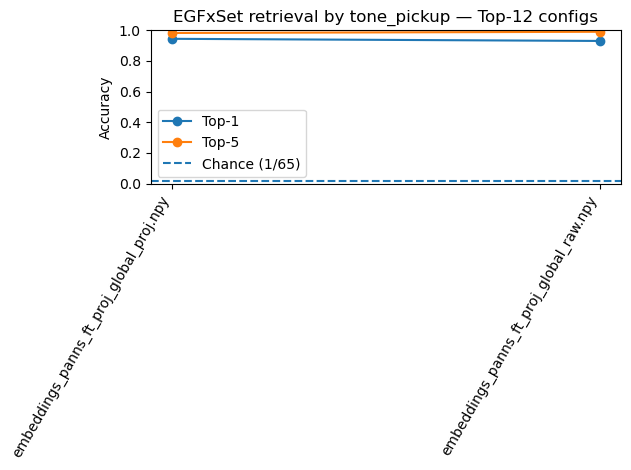

In [25]:
import numpy as np
import matplotlib.pyplot as plt

TOPN = 12

plot_df = res_df_eval.sort_values(["top1", "top5"], ascending=False).head(TOPN).copy()

x = np.arange(len(plot_df))
labels = plot_df["file"].tolist()

plt.figure()
plt.plot(x, plot_df["top1"].to_numpy(), marker="o", label="Top-1")
plt.plot(x, plot_df["top5"].to_numpy(), marker="o", label="Top-5")

chance = float(plot_df["chance"].iloc[0])
plt.axhline(chance, linestyle="--", label=f"Chance (1/{int(round(1/chance))})")

plt.xticks(x, labels, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.title(f"EGFxSet retrieval by tone_pickup — Top-{TOPN} configs")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Matriz de confusión (best embedding)

Construye la matriz de confusión para la mejor configuración.

1) Elegimos el mejor fichero según Top-1 (evaluado en VALIDACIÓN)
2) Cargamos embeddings (orden = df) y filtramos VALIDACIÓN
3) Normalizamos y calculamos vecino Top-1 SOLO dentro de validación
4) Matriz de confusión (conteos) y normalización por fila
5) Plot
(opcional) confusiones más frecuentes (sin diagonal)


Best embedding (by VAL): embeddings_panns_ft_proj_global_proj.npy


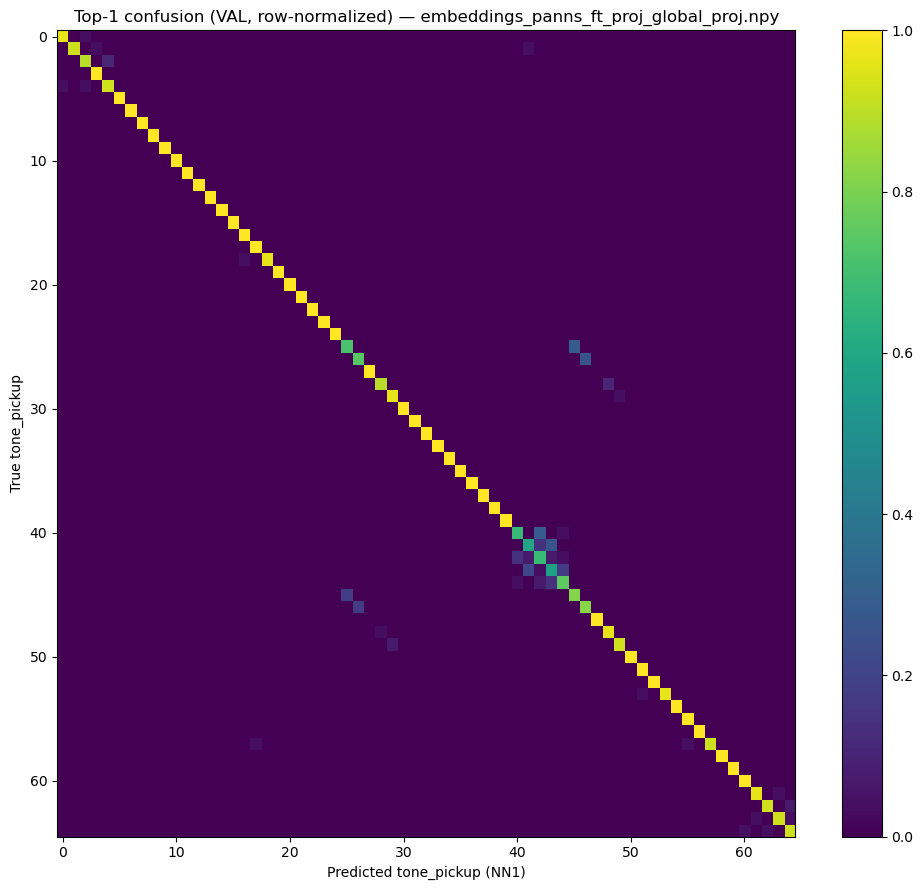

,row_0,col_0,count
0,RAT__Bridge,RAT__Middle,8
1,Hall Reverb__Bridge,Spring Reverb__Bridge,8
2,Hall Reverb__Bridge-Middle,Spring Reverb__Bridge-Middle,7
3,RAT__Bridge-Middle,RAT__Middle-Neck,7
4,RAT__Middle-Neck,RAT__Bridge-Middle,6
5,RAT__Middle-Neck,RAT__Neck,5
6,Spring Reverb__Bridge,Hall Reverb__Bridge,5
7,Spring Reverb__Bridge-Middle,Hall Reverb__Bridge-Middle,5
8,RAT__Neck,RAT__Middle-Neck,4
9,RAT__Bridge-Middle,RAT__Middle,4


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_file = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]["file"]
best_path = OUT_DIR_03 / best_file
print("Best embedding (by VAL):", best_file)

X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
labels_all = df["tone_pickup"].astype(str).to_numpy()

Xv = X[val_idx]
y_true = labels_all[val_idx]
assert Xv.shape[0] == len(y_true)

Xv = Xv / (np.linalg.norm(Xv, axis=1, keepdims=True) + 1e-9)
Sv = Xv @ Xv.T
np.fill_diagonal(Sv, -np.inf)
nn1 = np.argmax(Sv, axis=1)
y_pred = y_true[nn1]

cm = pd.crosstab(y_true, y_pred)  # filas: true, columnas: pred
cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)  # por fila

plt.figure(figsize=(10, 9))
plt.imshow(cm_norm.to_numpy(), aspect="auto")
plt.title(f"Top-1 confusion (VAL, row-normalized) — {best_file}")
plt.xlabel("Predicted tone_pickup (NN1)")
plt.ylabel("True tone_pickup")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_off = cm.copy()
for k in cm_off.index:
    if k in cm_off.columns:
        cm_off.loc[k, k] = 0

top_conf = (
    cm_off.stack()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
    .rename(columns={"level_0":"true", "level_1":"pred", 0:"count"})
)
top_conf


## 4. Tabla resumen de resultados

Misma tabla que en el baseline, pero etiquetando el modelo como fine-tuned.

In [27]:
tabla = res_df_eval.copy()

tabla["Configuración"] = tabla["file"]
tabla["Modelo"] = "PANNs CNN14 fine-tuned"
tabla["Capas usadas"] = "Global (interno)"
tabla["Pooling de capas"] = "Global pooling (modelo)"
tabla["Dimensión"] = tabla["dim"]
tabla["Top-1"] = tabla["top1"].round(3)
tabla["Top-5"] = tabla["top5"].round(3)
tabla["Veces mejor que azar"] = tabla["top1_vs_chance"].round(1)

tabla_final = tabla[
    ["Configuración", "Modelo", "Capas usadas", "Pooling de capas",
     "Dimensión", "Top-1", "Top-5", "Veces mejor que azar"]
].sort_values("Top-1", ascending=False)

tabla_final

,Configuración,Modelo,Capas usadas,Pooling de capas,Dimensión,Top-1,Top-5,Veces mejor que azar
0,embeddings_panns_ft_proj_global_proj.npy,PANNs CNN14 fine-tuned,Global (interno),Global pooling (modelo),256,0.945,0.983,61.4
1,embeddings_panns_ft_proj_global_raw.npy,PANNs CNN14 fine-tuned,Global (interno),Global pooling (modelo),2048,0.931,0.991,60.5


# 7. t-SNE (mismos gráficos y leyendas)

Repite los dos t-SNE del baseline:
- Uno global coloreado por `tone_pickup` (sin leyenda detallada)
- Subplots por `tone`, coloreando por `pickup` con **leyenda correcta**

--- t-SNE (PANNs fine-tuned) por tone_pickup (VALIDACIÓN) usando el mejor embedding ---
1) Selecciona el MEJOR embedding según evaluación en VALIDACIÓN (top1, luego top5)
2) Carga embeddings (orden = df) y filtra VALIDACIÓN
3) Normaliza
4) PCA previo
5) t-SNE
6) Plot (muchas clases -> sin leyenda)


Usando best_file: embeddings_panns_ft_proj_global_proj.npy | VAL top1=0.9447 | VAL top5=0.9827


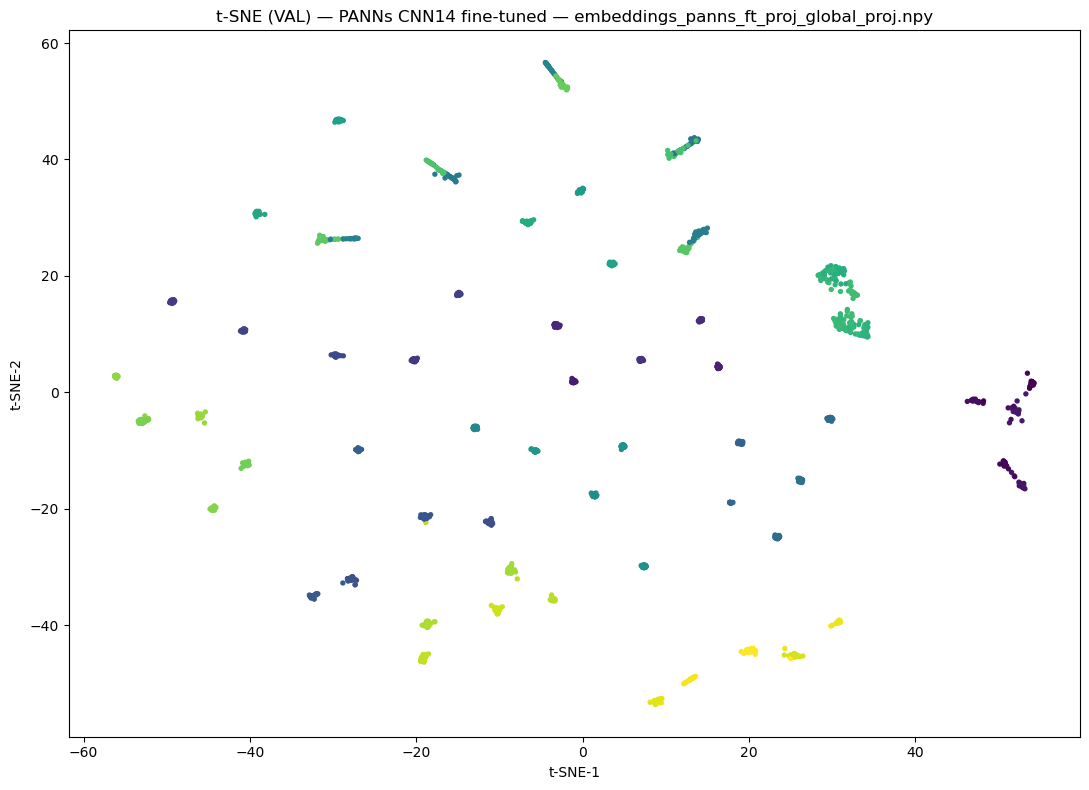

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

best_row = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]
best_file = best_row["file"]
best_top1 = best_row["top1"]
best_top5 = best_row["top5"]

best_path = OUT_DIR_03 / best_file
print(f"Usando best_file: {best_file} | VAL top1={best_top1:.4f} | VAL top5={best_top5:.4f}")

X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
labels_all = df["tone_pickup"].astype(str).to_numpy()

X = X[val_idx]
labels = labels_all[val_idx]

X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

pca_dim = min(50, X.shape[1])
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

N = X_pca.shape[0]
perplexity = max(5, min(30, (N - 1) // 3))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    random_state=42,
)
Z = tsne.fit_transform(X_pca)

uniq = sorted(set(labels.tolist()))
lab2i = {u:i for i,u in enumerate(uniq)}
c = np.array([lab2i[x] for x in labels], dtype=int)

plt.figure(figsize=(11, 8))
plt.scatter(Z[:, 0], Z[:, 1], c=c, s=8)
plt.title(f"t-SNE (VAL) — PANNs CNN14 fine-tuned — {best_file}")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.tight_layout()
plt.show()


t-SNE SUBPLOTS POR TONO (VALIDACIÓN) — leyenda arriba derecha
Elegir Z existente
Pickups -> ids
>>> MISMO colormap para puntos y leyenda <<<
Fondo gris
Tono actual (color = pickup)
LEYENDA GLOBAL ARRIBA DERECHA
Dejar espacio arriba para la leyenda


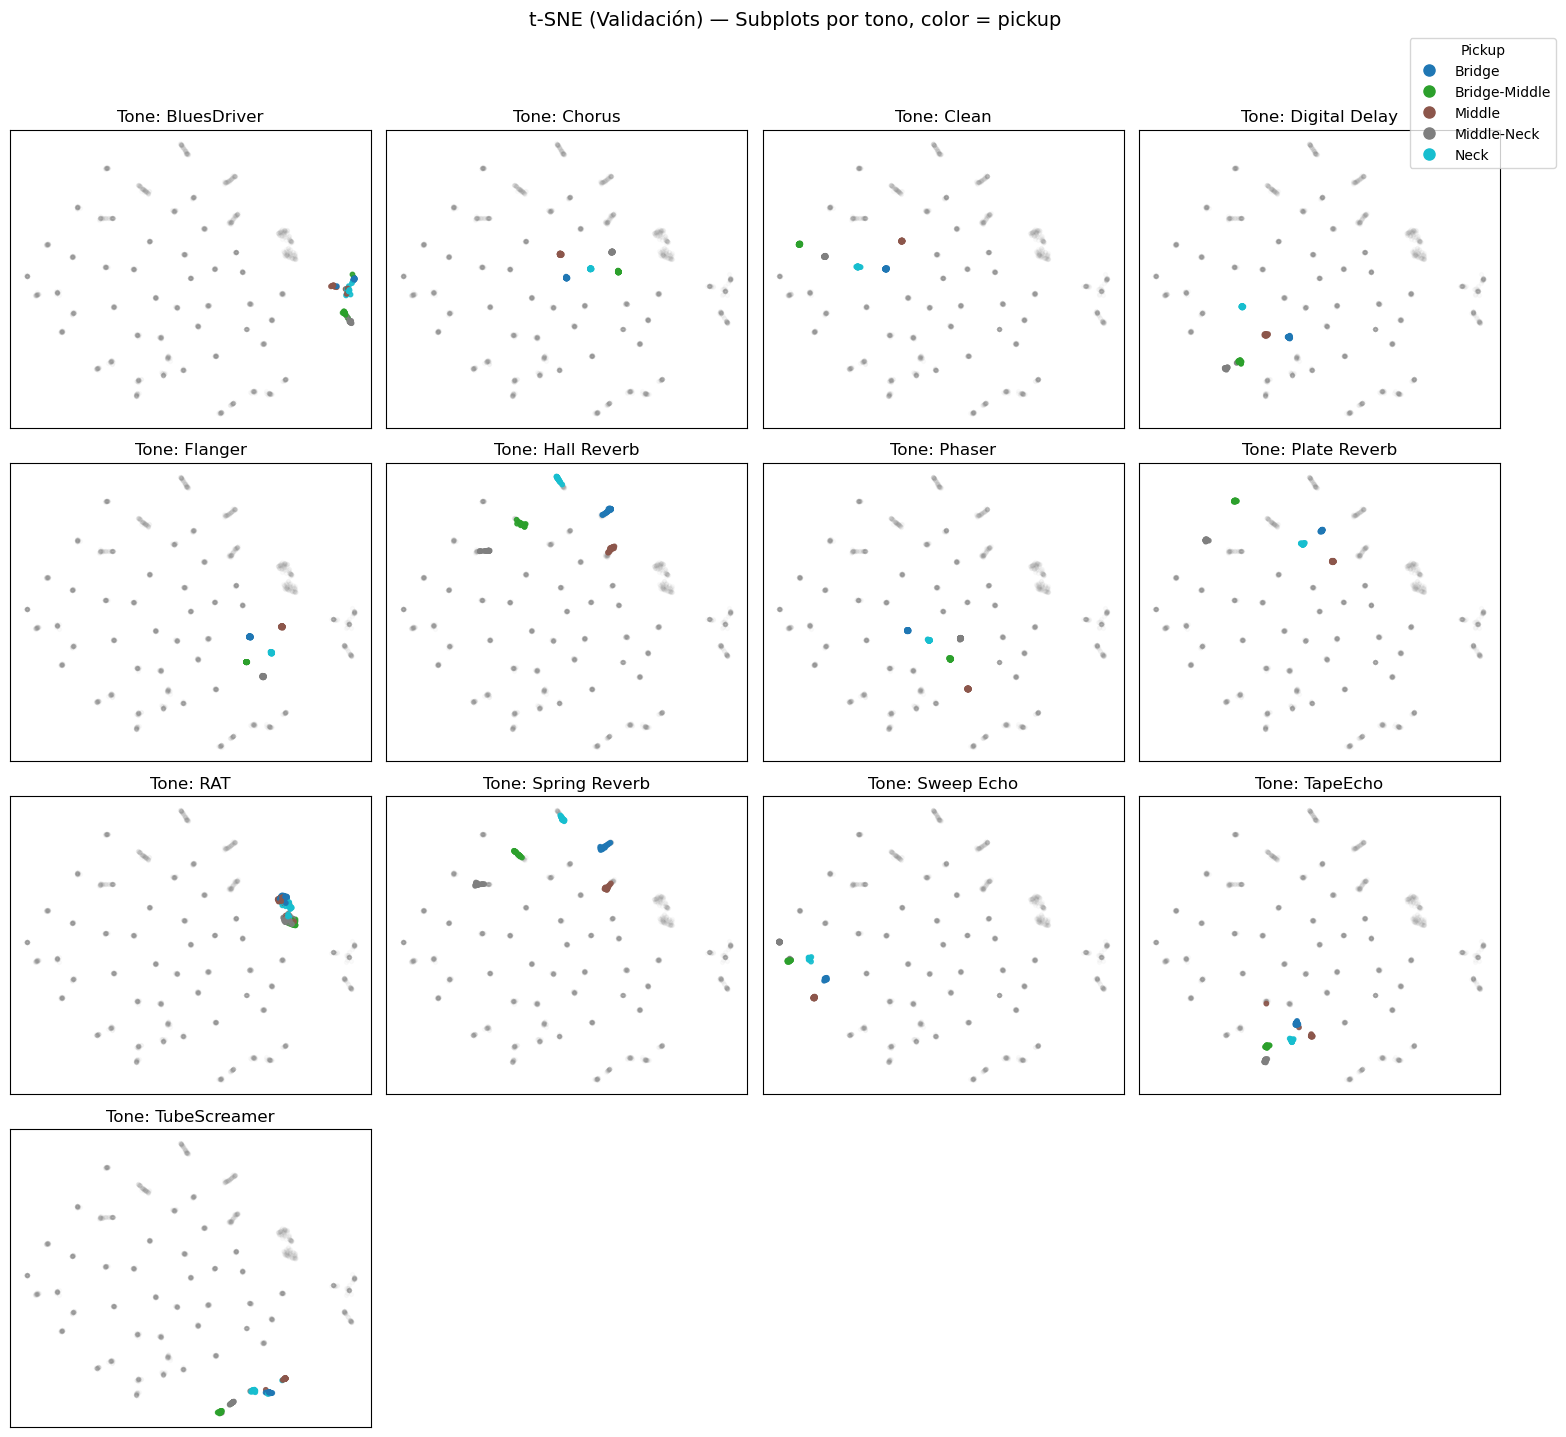

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

if "Z_val" in globals():
    Z_used = Z_val
elif "Z" in globals():
    Z_used = Z
else:
    raise NameError("No existe ni Z_val ni Z. Calcula el t-SNE antes (variable típica: Z).")

if "val_idx" not in globals():
    raise NameError("No existe val_idx. Necesito val_idx para alinear df con el t-SNE de validación.")

df_val = df.iloc[val_idx].copy().reset_index(drop=True)

assert Z_used.shape[0] == len(df_val), (
    f"El t-SNE tiene {Z_used.shape[0]} filas pero df_val tiene {len(df_val)}.\n"
    "Z debe corresponder a validación (mismo orden que val_idx)."
)

pickups = sorted(df_val["pickup"].astype(str).unique().tolist())
pickup_to_id = {p: i for i, p in enumerate(pickups)}
pickup_ids = df_val["pickup"].astype(str).map(pickup_to_id).to_numpy()

from matplotlib import colormaps
cmap = colormaps.get_cmap("tab10").resampled(max(len(pickups), 1))

tones = sorted(df_val["tone"].astype(str).unique().tolist())
n_tones = len(tones)

ncols = int(np.ceil(np.sqrt(n_tones)))
nrows = int(np.ceil(n_tones / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.6*nrows), squeeze=False)
axes = axes.ravel()

tone_arr = df_val["tone"].astype(str).to_numpy()

for i, t in enumerate(tones):
    ax = axes[i]
    m = (tone_arr == t)

    ax.scatter(Z_used[~m, 0], Z_used[~m, 1], s=8, alpha=0.03, color="grey")

    ax.scatter(
        Z_used[m, 0], Z_used[m, 1],
        c=pickup_ids[m],
        cmap=cmap,
        s=10, alpha=0.9,
        vmin=0, vmax=max(len(pickups)-1, 0)
    )

    ax.set_title(f"Tone: {t}")
    ax.set_xticks([]); ax.set_yticks([])

for j in range(n_tones, len(axes)):
    axes[j].axis("off")

legend_handles = [
    Line2D([0], [0], marker='o', linestyle='',
           markerfacecolor=cmap(i), markeredgecolor=cmap(i),
           markersize=8, label=p)
    for i, p in enumerate(pickups)
]

fig.legend(
    handles=legend_handles,
    title="Pickup",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=True
)

fig.suptitle("t-SNE (Validación) — Subplots por tono, color = pickup",
             y=0.995, fontsize=14)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])

plt.show()

# 8. Tabla de métricas de inferencia (fine-tuned)

Genera la tabla con las métricas de inferencia calculadas en los benchmarks.

--- Tabla de métricas de inferencia (PANNs) ---


In [30]:
import pandas as pd

rows = []
for d in [stats_e2e, stats_forward]:
    rows.append({
        "model": "PANNs fine-tuned",
        "variant": d.get("label", ""),
        "device": device,
        "n_runs": d.get("n", None),
        "mean_ms": d.get("mean_ms", None),
        "p50_ms": d.get("p50_ms", None),
        "p95_ms": d.get("p95_ms", None),
        "min_ms": d.get("min_ms", None),
        "max_ms": d.get("max_ms", None),
        "runs_per_s": d.get("runs_per_s", None),
    })

infer_panns_df = pd.DataFrame(rows).sort_values(["model", "variant"])
infer_panns_df


,model,variant,device,n_runs,mean_ms,p50_ms,p95_ms,min_ms,max_ms,runs_per_s
0,PANNs fine-tuned,E2E extract_panns_variants_ft (I/O+resample+fo...,mps,50,13.332363,13.106896,15.469664,11.250834,16.559084,75.005461
1,PANNs fine-tuned,FORWARD ONLY ft_model.panns(x),mps,200,5.919685,5.718042,7.288552,5.114417,8.333208,168.927908
